---

## Level 2 EVCS POI Candidate Selection

This section outlines the process of selecting POI (Point of Interest) candidates categorized by region.

- The above approach represents the process of selecting POI candidates categorized by region. POI filtering was applied when selecting POI candidates for all regions.
  
  - Before filtering, OSM_POI data was imported, and POIs were extracted for each categorized region (Atlanta, Suburban, Rural) using GIS tools.
  
  - For each extracted POI candidate, filtering was performed using the 'fclass' column, which contains information about building usage, utilizing GIS tools.

<br>

---

### Summary

- **Level 2 POI Candidate Selection**: Georgia, using GIS tools & filtering.  
<br>
---


# POI Candidate Selection Suburban

In [1]:
import geopandas as gpd
import pandas as pd
import yaml

from src import process_ev_charging_data, greedy_optimization, setup_logging

## Case 3: Suburban Level 2 EVCS Charger Initial Point Selection

In **Suburban areas**, POI candidates and their categories are diverse and highly reliable.  
Unlike other areas, the selection is influenced more by the **building category of the POI** than by the road network.

Therefore, a **weighted filtering** process is applied using the **Demand Map** and **POI building categories**. The algorithm proceeds as follows:

### Algorithm:

1. **Select priority POI categories**: This process is performed using GIS, where certain POI categories are prioritized for selection.
2. Assign **Demand Map values** to POI candidates, linking the demand levels to the POIs.
3. **Parse through the suburban polygon**, selecting POIs as initial points where demand is high and the POI matches a priority category.
4. If no POI exists for the selected category in a given region, the algorithm selects the POI with the highest demand from the **Demand Map** as the initial point.


In [2]:
# Load the YAML file with fclass categories
yaml_file_path = 'poi_filtering.yaml'

with open(yaml_file_path, 'r') as file:
    fclass_data = yaml.safe_load(file)

# Define the region and file paths
region = 'suburban'
gpkg_file_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/poi/osm_poi_filtered_candidate.shp'

# Load the fclass categories for initial and candidate filtering from the YAML data
if region in fclass_data['initial'] and region in fclass_data['candidate']:
    initial_fclasses = fclass_data['initial'][region]
    candidate_fclasses = fclass_data['candidate'][region]
else:
    raise ValueError(f"Region '{region}' not found in the YAML file for both initial and candidate.")

# Read the GPKG or Shapefile only once
poi_gdf = gpd.read_file(gpkg_file_path)
poi_gdf = poi_gdf.to_crs(epsg=3857)

# Step 1: Filter the POI data based on the initial fclass categories
initial_poi_gdf = poi_gdf[poi_gdf['fclass'].isin(initial_fclasses)]
initial_feature_count = initial_poi_gdf.shape[0]
print(f"Initial feature count for {region}: {initial_feature_count}")

# Step 2: Filter the POI data based on the candidate fclass categories
candidate_poi_gdf = poi_gdf[poi_gdf['fclass'].isin(candidate_fclasses)]
candidate_feature_count = candidate_poi_gdf.shape[0]
print(f"Candidate feature count for {region}: {candidate_feature_count}")

Initial feature count for suburban: 499
Candidate feature count for suburban: 9992


In [3]:
# Load the urban polygon file
urban_polygon_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/polygon/suburban_polygon.gpkg'

# Load the urban polygon data
urban_polygon_gdf = gpd.read_file(urban_polygon_path)
urban_polygon_gdf = urban_polygon_gdf.to_crs(epsg=3857)

# Assuming initial_poi_gdf and candidate_poi_gdf are already selected and loaded in memory

# Step 1: Calculate the initial feature count for the given region
initial_feature_count = initial_poi_gdf.shape[0]
print(f"Initial feature count for {region}: {initial_feature_count}")

# Step 2: Calculate the candidate feature count for the given region
candidate_feature_count = candidate_poi_gdf.shape[0]
print(f"Candidate feature count for {region}: {candidate_feature_count}")

# Perform any spatial operations, e.g., checking which POIs are within the urban polygons
initial_within_urban = gpd.sjoin(initial_poi_gdf, urban_polygon_gdf, how='inner', predicate='within')
candidate_within_urban = gpd.sjoin(candidate_poi_gdf, urban_polygon_gdf, how='inner', predicate='within')

# Print counts of points within urban polygons
print(f"Initial POIs within urban polygons: {initial_within_urban.shape[0]}")
print(f"Candidate POIs within urban polygons: {candidate_within_urban.shape[0]}")

# Step 3: Remove 'index_right' column if it exists before saving
if 'index_right' in initial_within_urban.columns:
    initial_within_urban = initial_within_urban.drop(columns=['index_right'])
    
if 'index_right' in candidate_within_urban.columns:
    candidate_within_urban = candidate_within_urban.drop(columns=['index_right'])

# Save the results
initial_within_urban_path = 'initial_within_suburban.gpkg'
candidate_within_urban_path = 'candidate_within_suburban.gpkg'

initial_within_urban.to_file(initial_within_urban_path, driver='GPKG')
candidate_within_urban.to_file(candidate_within_urban_path, driver='GPKG')

print(f"Initial POIs within urban polygons saved to {initial_within_urban_path}.")
print(f"Candidate POIs within urban polygons saved to {candidate_within_urban_path}.")

Initial feature count for suburban: 499
Candidate feature count for suburban: 9992
Initial POIs within urban polygons: 196
Candidate POIs within urban polygons: 3034
Initial POIs within urban polygons saved to initial_within_suburban.gpkg.
Candidate POIs within urban polygons saved to candidate_within_suburban.gpkg.


In [4]:
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from shapely.geometry import box

# File paths
polygon_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/polygon/suburban_polygon.gpkg'
demand_tif_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/demand_map_500.tif'
gpkg_file_path = '/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/poi/osm_poi_filtered_candidate.shp'

# 1. Load the suburban and urban region polygons
polygon_gdf = gpd.read_file(polygon_path)  # Load suburban region polygons
urban_polygon_gdf = gpd.read_file(urban_polygon_path)  # Load urban region polygons
urban_polygon_gdf = urban_polygon_gdf.to_crs(epsg=3857)

# 2. Load the POI data
poi_gdf = gpd.read_file(gpkg_file_path)
poi_gdf = poi_gdf.to_crs(epsg=3857)

# 3. Load the demand data from the TIFF file and convert the pixels to polygons
with rasterio.open(demand_tif_path) as src:
    affine = src.transform
    demand_data = src.read(1)  # Read the first band of the raster
    rows, cols = np.where(demand_data > 0)  # Select pixels with demand values
    
    demand_polygons = []
    demand_values = []
    
    for row, col in zip(rows, cols):
        # Convert the pixel coordinates to geographic coordinates (bottom-left and top-right)
        x_min, y_min = affine * (col, row)
        x_max, y_max = affine * (col + 1, row + 1)
        demand_polygons.append(box(x_min, y_min, x_max, y_max))  # Convert the pixel to a polygon
        demand_values.append(demand_data[row, col])  # Store the demand value

# 4. Convert the demand pixels into a GeoDataFrame
demand_gdf = gpd.GeoDataFrame({'demand': demand_values, 'geometry': demand_polygons}, crs="EPSG:3857")

# 5. Perform a spatial join to map demand values to initial POIs
poi_with_demand = gpd.sjoin(poi_gdf, demand_gdf, how='left', predicate='within')

# Step 6: Select the POI with the highest demand in each polygon
selected_pois = []

for _, polygon in polygon_gdf.iterrows():
    # Filter POIs that are within the current suburban polygon and have mapped demand values
    contained_poi = poi_with_demand[poi_with_demand.within(polygon.geometry)]
    
    if contained_poi.empty:
        continue
    
    # 1) Select the POI with the highest demand value
    max_demand_value = contained_poi['demand'].max()
    highest_demand_pois = contained_poi[contained_poi['demand'] == max_demand_value]
    
    # 2) If there are multiple POIs with the highest demand, select randomly
    selected_poi = highest_demand_pois.sample() if len(highest_demand_pois) > 1 else highest_demand_pois.iloc[[0]]
    
    selected_pois.append(selected_poi)

# Step 7: Save the selected POIs to a GeoDataFrame
if selected_pois:
    selected_pois_gdf = gpd.GeoDataFrame(pd.concat(selected_pois, ignore_index=True), crs='EPSG:3857')
    
    # Trim column names to 10 characters (to avoid issues with ESRI Shapefile column name limits)
    selected_pois_gdf.columns = [str(col)[:10] for col in selected_pois_gdf.columns]
    
    # Save the result as a .gpkg file
    selected_pois_gdf.to_file(f"suburban_initial_selected.gpkg", driver="GPKG")
    print(f"Selected POIs saved to suburban_initial_selected.gpkg")
    
else:
    print("No POIs were selected.")

# Step 8: Now handle the urban polygons and check POIs within them
# Perform spatial join to check which POIs are within the urban polygons
initial_within_urban = gpd.sjoin(poi_gdf, urban_polygon_gdf, how='inner', predicate='within')

# Step 9: Remove 'index_right' column if it exists before saving
if 'index_right' in initial_within_urban.columns:
    initial_within_urban = initial_within_urban.drop(columns=['index_right'])

# Save the results
initial_within_urban_path = 'initial_within_suburban.gpkg'
initial_within_urban.to_file(initial_within_urban_path, driver='GPKG')

print(f"Initial POIs within urban polygons saved to {initial_within_urban_path}.")

Selected POIs saved to suburban_initial_selected.gpkg
Initial POIs within urban polygons saved to initial_within_suburban.gpkg.


Initial POIs within suburban polygons: 5470
Candidate POIs within suburban polygons: 3034
Data saved to suburban_lv2_greedy.gpkg
Data saved to suburban_lv2_mclp_selected.gpkg


/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/src/utils.py:171: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[0].legend()


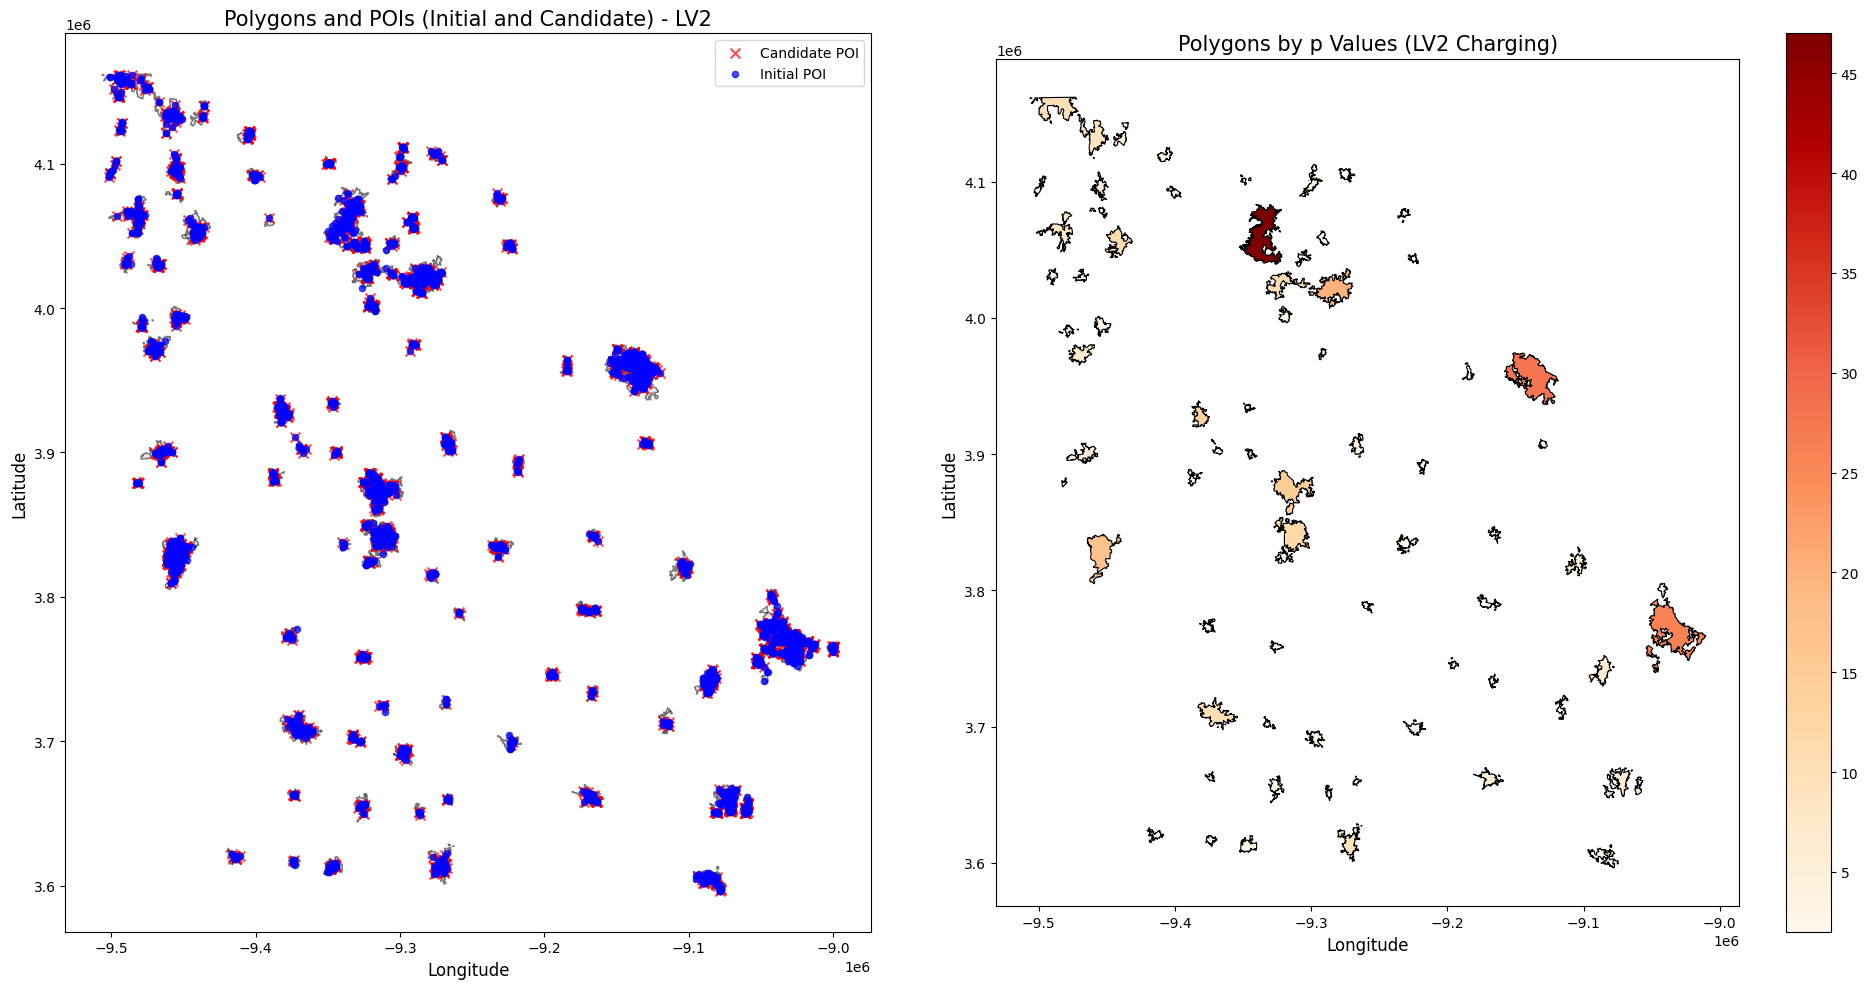

In [5]:
# Example usage
process_ev_charging_data(
    region_type='suburban',
    initial_pois_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/initial_within_suburban.gpkg',
    candidate_pois_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/candidate_within_suburban.gpkg',
    polygons_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/polygon/suburban_polygon.gpkg',
    charger_type='lv2',
    urban_polygons_path='/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/polygon/suburban_polygon.gpkg',
    save=True
)

In [6]:
# Set up logging
setup_logging()

gpkg_file = "/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/suburban_trip_greedy.gpkg"
tif_file = "/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/demand_map_500.tif"
poi_file = "/home/sehoon/Desktop/ACM-SIGSPATIAL-Cup-2024/data/initial_candidate_poi/Suburban_POI_Candidate.gpkg"
output_path = "./results/urban_lv2/"

# Read input files
polygons = gpd.read_file(gpkg_file)
poi_gdf = gpd.read_file(poi_file)

for _, polygon in polygons.iterrows(): 
    greedy_optimization(
        polygon, 
        tif_file, 
        poi_gdf, 
        capture_range=4000, 
        bandwidth=1500, 
        constraints=(1, None), 
        output_path=output_path,
        save_intermediate=True
    )

2024-09-28 22:07:03,333 - INFO - 
*** Processed Polygon Information ***
----------------------------------------------------
Polygon ID            : Adairsville, GA Urban Area
Total Supply          : 6.0
A_bar Value           : 0.0036
Selected Initial Sites: 1
Initial Coverage      : 64.36%
2024-09-28 22:07:11,649 - INFO - Selecting site  2/ 2 | Selected Site:   4 | A_hat: 0.00347 | Coverage:  64.36%
2024-09-28 22:07:11,834 - INFO - Optimization process for Adairsville, GA Urban Area complete
2024-09-28 22:07:11,993 - INFO - 
*** Processed Polygon Information ***
--------------------------------------------------
Polygon ID            : Adel, GA Urban Area
Total Supply          : 6.0
A_bar Value           : 0.0031
Selected Initial Sites: 1
Initial Coverage      : 73.61%
2024-09-28 22:07:13,283 - INFO - Selecting site  2/ 2 | Selected Site:   2 | A_hat: 0.00271 | Coverage:  73.61%
2024-09-28 22:07:13,294 - INFO - Optimization process for Adel, GA Urban Area complete
2024-09-28 22:07:13,

KeyboardInterrupt: 